# The El Farol Bar problem

The El Farol bar problem is a problem in game theory. Every Thursday night, a fixed population want to go have fun at the El Farol Bar, unless it's too crowded.

- If less than 60% of the population go to the bar, they'll all have more fun than if they stayed home.
- If more than 60% of the population go to the bar, they'll all have less fun
  than if they stayed home.

Everyone must decide at the same time whether to go or not, with no knowledge of
others' choices.


It was defined by economist William Brian Arthur in 1994. He wrote a paper about
it, you can read it
[here](https://sites.santafe.edu/~wbarthur/Papers/El_Farol.pdf) if you are
interested

In the paper, every person (called agent) has access to some ways to predict how
many people will come next week (called hypothesis).

This notebook recreates this problem as a way to learn the student about classes
and functions.

# Hypotheses

First, let's load the hypothesis class. Study the file `hypotheses.py` inside
the `elfarol` folder to see what is going on.

In [1]:
import elfarol.hypotheses as hypt
hypotheses = hypt.Hypotheses(n=[1, 3, 6], fixed=True)
hypotheses

Hypotheses(models=['average_4w', 'cycle4w', 'random'])

A Hypotheses is a class that has 8 different hypotheses implemented as a
function. The types of hypotheses are taken from the paper. When an instance of Hypotheses is created, you can select how many
hypotheses are actually available. 

There are two ways to do this:
- **fixed**: if `fixed` is `True`, you can pass a `List[int]` to `n`. In the
  example above, the hypotheses number 1, 3 and 6 are selected
- **unfixed** else, a random selection of `n` hypotheses is made. So `n=3` will
  select three hypothesis at random. With `n=0` the default naive hypothesis is
  selected, which is 'last_week': the prediction is that there will be as much
  people as last week.

In [2]:
hypotheses = hypt.Hypotheses(n=0)
hypotheses

Hypotheses(models=['lastweek'])

In [3]:
hypotheses = hypt.Hypotheses(n=5)
hypotheses

Hypotheses(models=['cycle5w', 'cycle4w', 'mirror', 'average_4w', 'lastweek'])

If we feed a `Hypotheses` a history with a list of integers, every hypotheses
will make a prediction.

In [4]:
hist = [70, 60, 52, 80, 79]

In [5]:
for model in hypotheses.models:
    yhat = model(hist[:-1])
    diff = abs(yhat - hist[-1])
    print(f"{model.__name__} : {yhat} ({diff})")

_cycle5w : 70.0 (9.0)
_cycle4w : 70.0 (9.0)
_mirror : 20.0 (59.0)
_average_4w : 65.5 (13.5)
_lastweek : 80.0 (1.0)


# Agents

Next, study the `agents.py` file. First, we have a `BaseAgent` class.

In [6]:
from elfarol.agents import BaseAgent
baseagent = BaseAgent(threshold=60)
baseagent

Agent(threshold=60, model=Hypotheses(models=['lastweek']))

The `BaseAgent` implements the methods:
- `_get_threshold`: returns the threshold. Default 60
- `_predict`: retrieves a model and returns a prediction
- `_getmodel`: receives a history, and returns the best model (a Callable that
  inputs a List[int] and outputs a float) that can make a
  prediction for given history. The `BaseAgent` only has the naive model
  available, so the history is ignored.
- `decide`: an Agent should be able to decide if he goes to the bar, depending
  on the prediction he makes and the threshold he has.

For every agents, the `len` of the agents is the amount of models. For the
`BaseAgent`, this length is 1.

In [7]:
len(baseagent.hypotheses)

1

And it has just one model

In [8]:
baseagent._getmodel(hist=hist[:-1]).__name__

'_lastweek'

That makes predictions

In [9]:
baseagent._predict(hist=hist[:-1])

80.0

And decisions.

In [10]:
baseagent.decide(hist)

False

# Inheritance
Now, why use a `BaseAgent`? It is the most simple and generic case of an Agent.
We can now implement a new type of `BaseAgent`, lets call it the `Agent` class.
That class will inherit all the methods from the `BaseAgent`, but it will
implement a new method for `_getmodel`. 

The `Agent` actually tests all models available to see how well the model would
have performed if he would have used this model last week.

Let's create an `Agent`:

In [11]:
from elfarol.agents import Agent
agent = Agent(n=10, threshold=60)
agent

2021-12-06 14:07:41.728 | INFO     | elfarol.hypotheses:__init__:39 - Max value of n is 8, found 10


Agent(threshold=60, model=Hypotheses(models=['cycle2w', 'average_4w', 'cycle4w', 'lastweek', 'random', 'cycle5w', 'mirror', 'trend']))

We can see it has 8 different hypotheses.

In [12]:
len(agent.hypotheses)

8

And, based on the current history, it will select one model:

In [13]:
agent._getmodel(hist).__name__

'_lastweek'

And will make a prediction with the best model:

In [14]:
agent._predict(hist)

79.0

And can decide, based on that decision

In [15]:
agent.decide(hist)

False

# Saturday night

In [16]:
from scipy import stats
import seaborn as sns

So, now we have everything in place. Let's create a 100 `BaseAgents`

In [17]:
visitors = 100
agents = [BaseAgent(threshold=60) for _ in range(visitors)]
agents[0]

Agent(threshold=60, model=Hypotheses(models=['lastweek']))

And simulate 52 saturday nights. We will start with a value of 100, because
everybody was invited to the first evening.

<AxesSubplot:>

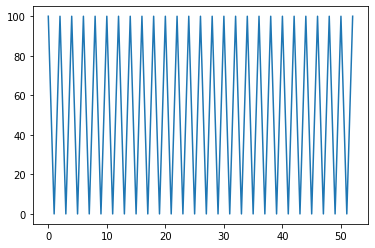

In [18]:
from elfarol.bar import  saturdaynight

hist = [100]
for _ in range(52):
    hist = saturdaynight(agents, hist)
sns.lineplot(x = range(len(hist)), y = hist)

Interesting! What is going on: last week, there where a 100 visitors. They all
have just one model, that predicts: next week there will be the same amount of
people. 100 is too much, so nobody comes. The week after that, they all predict
no one will come (based on last week) so everybody comes. This will bounce
between 0 and 100.


Well, maybe the problem is the threshold. People will have different preferences.

In [19]:
tresholds = stats.poisson(60).rvs(visitors)
tresholds

array([51, 63, 56, 54, 53, 61, 66, 70, 60, 52, 52, 53, 51, 77, 58, 63, 67,
       42, 51, 65, 67, 62, 61, 74, 69, 61, 72, 67, 52, 56, 69, 69, 61, 63,
       69, 67, 58, 68, 76, 57, 64, 60, 57, 53, 59, 68, 54, 59, 72, 59, 65,
       60, 50, 61, 58, 67, 53, 55, 68, 62, 51, 59, 55, 60, 49, 62, 73, 48,
       50, 67, 54, 59, 41, 62, 57, 56, 55, 58, 61, 64, 64, 61, 50, 56, 56,
       68, 64, 47, 61, 64, 72, 47, 60, 62, 66, 65, 75, 53, 66, 58])

<AxesSubplot:>

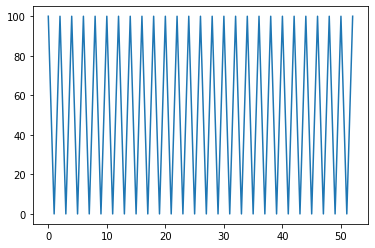

In [20]:
agents = [BaseAgent(threshold=t) for t in tresholds]
hist = [100]
for _ in range(52):
    hist = saturdaynight(agents, hist)
sns.lineplot(x = range(len(hist)), y = hist)

Same result....

Now, let's switch to the `Agent` that can pick between models.

<AxesSubplot:>

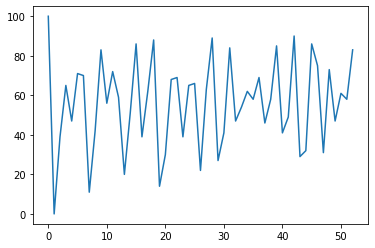

In [21]:
agents = [Agent(n=2) for _ in range(visitors)]
hist = [100]
for _ in range(52):
    hist = saturdaynight(agents, hist)
sns.lineplot(x = range(len(hist)), y = hist)

Ok, this is starting to look a bit more natural. Let's make the amount of
hypotheses vary between every `Agent`

<AxesSubplot:ylabel='Count'>

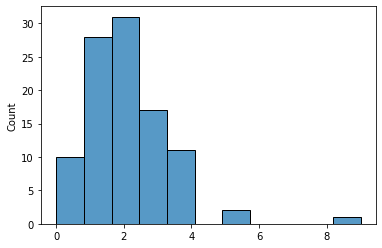

In [22]:
N = stats.poisson(2).rvs(visitors)
sns.histplot(N)

2021-12-06 14:07:57.825 | INFO     | elfarol.hypotheses:__init__:39 - Max value of n is 8, found 9


<AxesSubplot:>

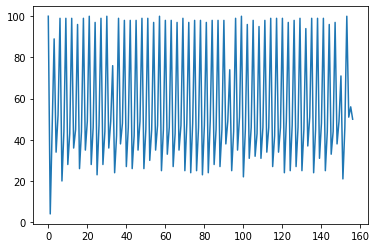

In [23]:
agents = [Agent(n=int(n)) for n in N]
hist = [100]
for _ in range(52 * 3):
    hist = saturdaynight(agents, hist)
sns.lineplot(x = range(len(hist)), y = hist)

<AxesSubplot:>

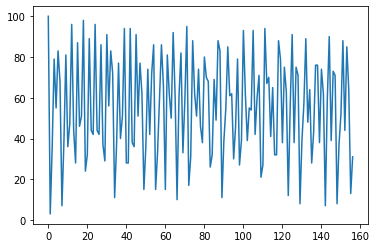

In [24]:
N = stats.poisson(3).rvs(visitors)
agents = [Agent(n=int(n)) for n in N]
hist = [100]
for _ in range(52 * 3):
    hist = saturdaynight(agents, hist)
sns.lineplot(x = range(len(hist)), y = hist)

# Excercise 1
Add another type of `Agent`, the `MoodyAgent`. This new type of agent will have
a varying threshold. So:

- implement a new type that inherits from `BaseAgent` called `MoodyAgent`
- create noise with `np.random.randint` with parameters `low=-9` and `high=10` (this
  will give a mean of 0), everytime
  `._get_threshold` is called and add this noise to the threshold
- modify the `.decide` function for the `MoodyAgent`, such that the in the
  comparison between the predicted `yhat` and the threshold, the function
  `._get_threshold` is called and every week the threshold has a slight
  variation (based on the mood of the agent)

In [25]:
%load_ext autoreload
%autoreload 2
from elfarol.agents import MoodyAgent
import seaborn as sns

In [26]:
import numpy as np
np.random.seed(123)
agent = MoodyAgent(2, threshold=60)
agent

Agent(threshold=64, model=Hypotheses(models=['lastweek', 'random']))

In [27]:
thresholds = [agent._get_threshold(agent.threshold) for _ in range(int(1e3))]

<AxesSubplot:ylabel='Count'>

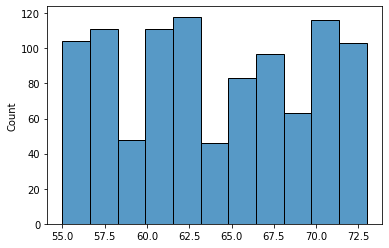

In [28]:
sns.histplot(thresholds)

In [29]:
assert np.abs(np.mean(thresholds) - agent.threshold) < 0.5
assert np.std(thresholds) > 5

# Excercise 2

Inside the `bar.py` file, create two classes:

- A `BaseExperiment` class that implements the `saturdaynight` and `simulate`
  functions, but without plotting
- A property of the object, that stores the history in self.hist. Update this
  self.history with new experiments.
- Add a method `.reset` that resets the history
- a property `self.agents` that stores the agents list at creation
- `.simulate` wont need `agents` as an argument, but can use the `self.agents`

With this Base class, add:
- An `Experiment` class that inherits from this `BaseExperiment` and implements
  multiple visualisation options

Add as visualisations:
- the simple lineplot  of the last experiments
- a plot function that creates a histogram for the amount of hypotheses of the
  agents
- a barplot that will collect the distribution of the hypotheses used. This
  should answer the question: which hypotheses are used most often by the
  agents, during the length of the experiment?

In [30]:
from elfarol.bar import Experiment
from elfarol.agents import MoodyAgent
from scipy import stats

In [31]:
agent = MoodyAgent(8)
agent

Agent(threshold=56, model=Hypotheses(models=['cycle4w', 'mirror', 'average_4w', 'lastweek', 'cycle5w', 'trend', 'random', 'cycle2w']))

But after the agent made a decision

In [36]:
agent.decide([60, 65, 55])
agent.log

['_cycle4w', '_cycle4w']

The log keeps track of which model has been used.

In [37]:
visitors = 100
N = stats.poisson(2).rvs(visitors)


In [38]:
agents = [MoodyAgent(int(n)) for n in N]
agents[0]

Agent(threshold=63, model=Hypotheses(models=['mirror', 'cycle5w']))

# Experiment Class

In [39]:
exp = Experiment(agents=agents)

We can run experiments for 52 weeks

In [40]:
hist = exp.simulate(k=52)

And call a line plot

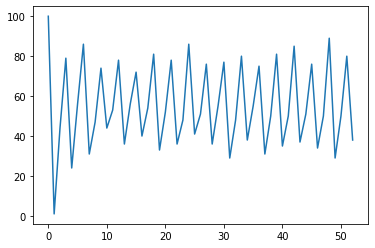

In [41]:
exp.line()

Visualize the amount of hypotheses for agents

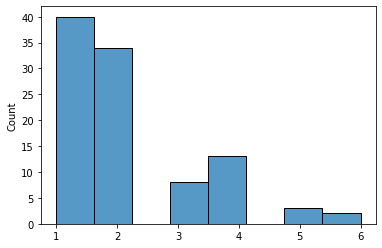

In [42]:
exp.hist_n_hypotheses()

Check the distribution of the models available

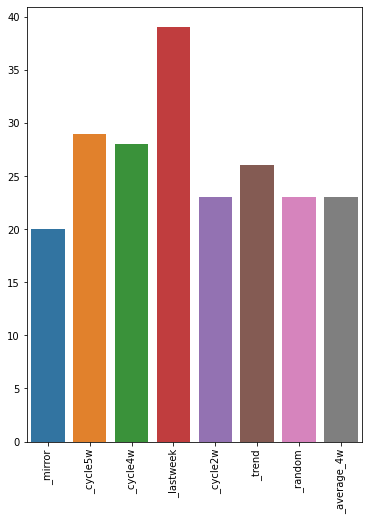

In [46]:
exp.bar_hypt_population(figsize=(6,8))

To the MoodyAgent, I added a .log property. Everytime a decision is made, the
name of the model used for the decision is added to the log.

In [51]:
len(exp.agents[0].log)

52

After 52 weeks, we see that the first agents has used 52 times a model, which
makes sense. We can use a list comprehension to flatten this list

In [60]:
models_used = [name for x in exp.agents for name in x.log]
len(models_used)

5200

And we get 52*100 models used.

2021-12-06 14:29:23.491 | INFO     | elfarol.bar:bar_log:77 - Found 5200 models.


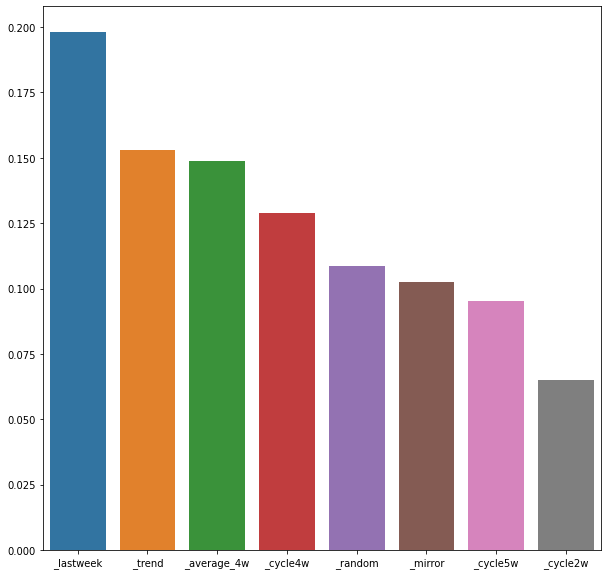

In [91]:
exp.bar_log()